# Exploration of Qwen2.5-VL-7B as Description Extractor

This notebook contains the exploration of using the Qwen2.5-VL-7B model as a description extractor. Here we are evaluating the model's ability to accurately gleam visual details about the clothing image. We are comparing against the product descriptions and clothing images released by H&M. The dataset can be found here: https://huggingface.co/datasets/tomytjandra/h-and-m-fashion-caption

In [ ]:
%%capture
# Install required packages
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit_learn
!pip install keras
!pip install tensorflow
!pip install huggingface_hub[hf_transfer]
!pip install qwen-vl-utils[decord]==0.0.8
!pip install bert-score
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub

import os
import random
from PIL import Image
import tempfile
import requests
import io
import base64

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay
from bert_score import BERTScorer

import torch
from huggingface_hub import hf_hub_download, snapshot_download
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

In [ ]:
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

repo_id = "tomytjandra/h-and-m-fashion-caption"

ds_path = snapshot_download(repo_id=repo_id, repo_type="dataset")
print(f"Dataset downloaded to: {ds_path}")

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/502 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train-00000-of-00016.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00005-of-00016.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

train-00002-of-00016.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

train-00004-of-00016.parquet:   0%|          | 0.00/386M [00:00<?, ?B/s]

train-00003-of-00016.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00001-of-00016.parquet:   0%|          | 0.00/540M [00:00<?, ?B/s]

train-00006-of-00016.parquet:   0%|          | 0.00/372M [00:00<?, ?B/s]

train-00007-of-00016.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00008-of-00016.parquet:   0%|          | 0.00/359M [00:00<?, ?B/s]

train-00009-of-00016.parquet:   0%|          | 0.00/338M [00:00<?, ?B/s]

train-00010-of-00016.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

train-00011-of-00016.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

train-00013-of-00016.parquet:   0%|          | 0.00/341M [00:00<?, ?B/s]

train-00014-of-00016.parquet:   0%|          | 0.00/338M [00:00<?, ?B/s]

train-00012-of-00016.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00015-of-00016.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

Dataset downloaded to: /root/.cache/huggingface/hub/datasets--tomytjandra--h-and-m-fashion-caption/snapshots/2083a7e30878af2993632b2fc3565ed4a2159534


In [ ]:
# Get a list of all parquet files in the directory
parent_dir = ds_path + "/data/"
parquet_files = os.listdir(parent_dir)

# Create an empty list to store the dataframes
dfs = []

# Iterate over the parquet files and read them into dataframes
for file in parquet_files:
  print(file)
  if file.endswith('.parquet'):
    df = pd.read_parquet(parent_dir + file)
    dfs.append(df)

# Concatenate all the dataframes into a single dataframe
full_df = pd.concat(dfs)

# Print some info to check if it worked
full_df.info()

train-00000-of-00016.parquet
train-00002-of-00016.parquet
train-00010-of-00016.parquet
train-00014-of-00016.parquet
train-00008-of-00016.parquet
train-00005-of-00016.parquet
train-00003-of-00016.parquet
train-00015-of-00016.parquet
train-00009-of-00016.parquet
train-00004-of-00016.parquet
train-00006-of-00016.parquet
train-00013-of-00016.parquet
train-00011-of-00016.parquet
train-00012-of-00016.parquet
train-00007-of-00016.parquet
train-00001-of-00016.parquet
<class 'pandas.core.frame.DataFrame'>
Index: 20491 entries, 0 to 1280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20491 non-null  object
 1   image   20491 non-null  object
dtypes: object(2)
memory usage: 480.3+ KB


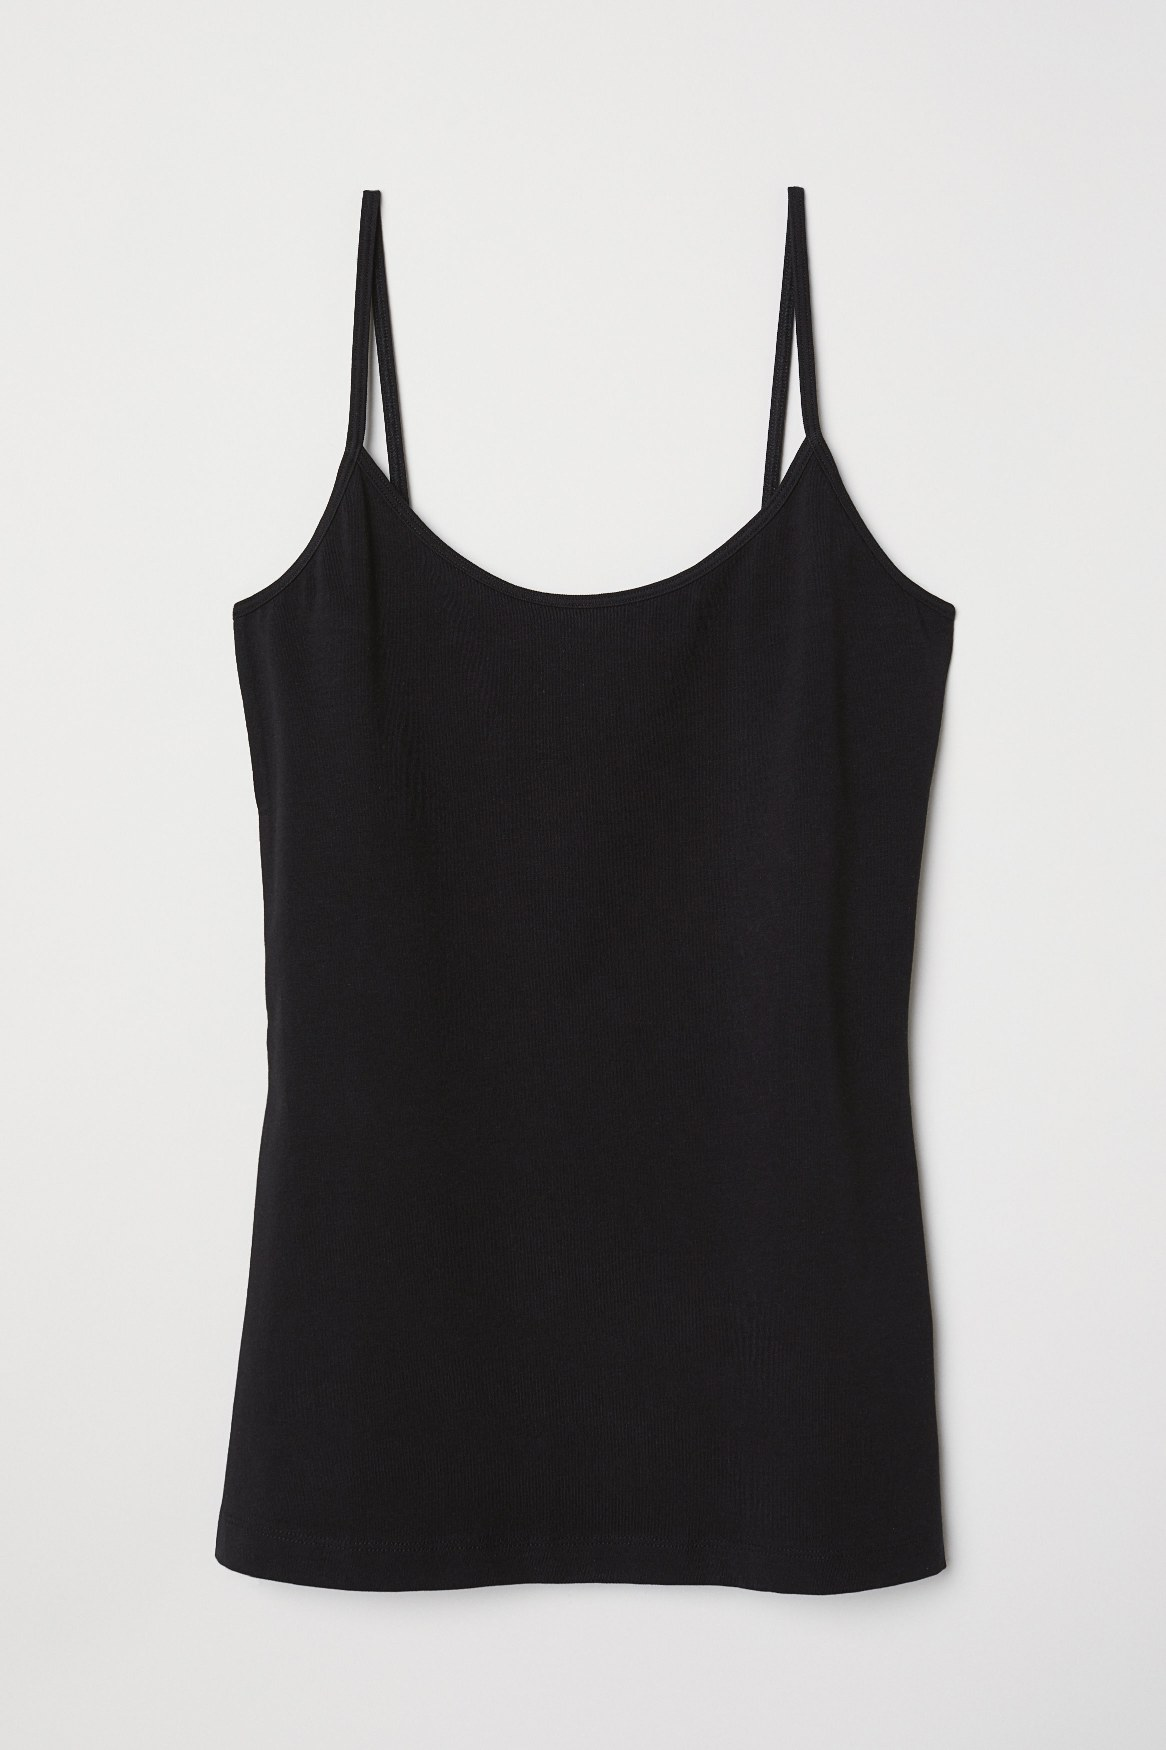

In [ ]:
# view sample image
byte_data = full_df.iloc[0]['image']['bytes']
img = Image.open(io.BytesIO(byte_data))
img

### Create random subset of 2000 images to evaluate on

In [ ]:
#val_set = full_df.sample(n=2000, random_state=42)
val_set = full_df.sample(n=500, random_state=42)
val_set.head(5)

,text,image
480,contrast black jacket in fast-drying functiona...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
830,front print black short-sleeved sports top in ...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1169,lace white straight-cut blouse in a cotton wea...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1169,other structure black tailored trousers in a s...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
960,treatment greenish khaki long airy top in soft...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


## Download Model

In [ ]:
# Define the model repository ID
repo_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# Download the model file using hf_transfer
file_path = snapshot_download(repo_id)

print(f"Model downloaded to: {file_path}")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-7B-Instruct/snapshots/6e6556e8ce728c7b3e438d75ebf04ec93403dc19


In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# first prompt is simple and used as a baseline to compare, second take few shot approach
prompt1 = "Describe the product item in the image."
print(prompt1)

prompt2 = "Here are sample descriptions of other products: \"melange dark grey trousers in sweatshirt fabric with an elasticated drawstring waist side pockets\", \"solid black leggings in soft jersey with a wide panel at the waist for best fit over the tummy\", \"solid black short padded jacket with a jersey-lined hood and stand-up collar with a drawstring zip down the front flap side pockets\". Answer only with a description for the product item shown in the image. Use the same style as the sample descriptions."
print(prompt2)

Describe the product item in the image.
Here are sample descriptions of other products: "melange dark grey trousers in sweatshirt fabric with an elasticated drawstring waist side pockets", "solid black leggings in soft jersey with a wide panel at the waist for best fit over the tummy", "solid black short padded jacket with a jersey-lined hood and stand-up collar with a drawstring zip down the front flap side pockets". Answer only with a description for the product item shown in the image. Use the same style as the sample descriptions.


### Try out the first prompt on one sample

In [ ]:
# helper function to prepare img byte data to be ingested by model
def bytes_to_base64_image(df, idx):
    """Converts image bytes to a Base64 encoded string."""
    image_bytes = df.iloc[idx]['image']['bytes']
    return "data:image;base64," + base64.b64encode(image_bytes).decode('utf-8')


# define message with first image and prompt1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image":  bytes_to_base64_image(val_set, 0),
            },
            {"type": "text", "text": prompt1},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The image shows a black and white track jacket from H&M Sport. The jacket features a full-length zipper with a black zipper pull, a stand-up collar, and long sleeves. The sleeves have white panels on the sides, adding a contrast to the predominantly black body of the jacket. There are two side pockets with flaps, and the cuffs of the sleeves are also black. The jacket appears to be made of a lightweight, breathable fabric suitable for casual wear or light athletic activities.']


### Try second prompt on one sample

In [ ]:
# define message with first image and prompt2
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image":  bytes_to_base64_image(val_set, 0),
            },
            {"type": "text", "text": prompt2},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['Solid black long padded coat with a hood and button-down front, featuring two patch pockets on the sides.']


### Generate Descriptions for full validation set

(TODO update based on res) Reducing image size again for gpu memory constraints. Reduced by half this time. Majority (81%) of the images in the dataset have between 913-1.18k px.

In [ ]:
# took ~ 51min on A100
true_descriptions = []
pred_descriptions = []

for index, row in val_set.iterrows():
  byte_data = row['image']['bytes']
  img = Image.open(io.BytesIO(byte_data))

  # Get original dimensions
  width, height = img.size

  # Calculate new dimensions (half size)
  new_width = width // 2
  new_height = height // 2

  # Resize the image
  resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

  # Create a temporary file path
  temp_path = os.path.join(tempfile.gettempdir(), 'resized_image.png')

  # Save the resized image to temp path
  resized_img.save(temp_path)

  # define message with image and prompt
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": temp_path,
              },
              {"type": "text", "text": prompt2},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=128)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # save output
  pred_descriptions.append(output_text[0])
  true_descriptions.append(row["text"])
  os.remove(temp_path)


In [ ]:
# view generated descriptions
pred_descriptions[0:5]

['solid black long padded coat with a jersey-lined hood and stand-up collar, buttoned front, side pockets, and a straight hemline.',
 'melange dark grey oversized T-shirt with a crew neck and short sleeves, featuring the word "MERCY" printed in a distressed blue font across the chest.',
 'black puff-sleeved dress in smooth fabric with a deep V-neckline and a concealed zipper at the back',
 'Navy blue trench coat with a buttoned collar, long sleeves, and two patch pockets on the front.',
 'White off-the-shoulder blouse with tie details on the sleeves and a gathered neckline.']

## Evaluate Generated Description against "Ground Truth"

For our initial evaluation, we will use the cosine similarity (using 'all-MiniLM-L6-v2' embeddings), BLEU score and BERTScore to measure how semantically similar the generated descriptions are when compared to the original descriptions from the dataset.

Note: Just because the generated description isn't semantically similar to the original description in the dataset, that doesn't mean that the descriptions won't be helpful in cataloging + generating recommendations. We just want to make sure that the generated answers describe the product accurately and it isn't hallucinating wrong qualities about the product. A better evaluation strategy may be to use a LLM as a judge, and ask the LLM to score the generated answer based on if it was missing qualities or contains contradictory qualities when compared to the original product description. Could be something to consider for later iteration.

In [ ]:
# helper functions to compute metrics
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer

def compute_bert_score(generated_answers, reference_answers):
  # Initialize the BERTScorer
  scorer = BERTScorer(lang="en")

  # Compute the scores
  P, R, F1 = scorer.score(generated_answers, reference_answers)

  # Return values
  return P, R, F1

def compute_cosine_similarity(generated_answers, reference_answers):
  res = []
  emb_model = SentenceTransformer('all-MiniLM-L6-v2')

  for gen_answer, ref_answer in zip(generated_answers, reference_answers):
    gen_answer_emb = emb_model.encode(gen_answer)
    ref_answer_emb = emb_model.encode(ref_answer)
    # compute cosine similarity
    cos_sim = np.dot(gen_answer_emb, ref_answer_emb) / (np.linalg.norm(gen_answer_emb) * np.linalg.norm(ref_answer_emb))
    res.append(cos_sim)

  res = np.array(res)
  avg_similiarity = np.mean(res)

  return avg_similiarity

def compute_bleu_score(generated_answers, reference_answers):
  bleu_scores = []
  for gen_answer, ref_answer in zip(generated_answers, reference_answers):
    bleu_scores.append(sentence_bleu([ref_answer.split()], gen_answer.split()))

  return bleu_scores


def compute_metrics(generated_answers, reference_answers):
  # compute the BERTScore
  bert_P, bert_R, bert_F1 = compute_bert_score(generated_answers, reference_answers)

  # compute cosine similarity from embedding
  cosine_sim = compute_cosine_similarity(generated_answers, reference_answers)

  # compute bleu scores
  bleu_scores = compute_bleu_score(generated_answers, reference_answers)

  # create dataframe of full results
  full_results = pd.DataFrame()
  full_results['bert_P'] = bert_P
  full_results['bert_R'] = bert_R
  full_results['bert_F1'] = bert_F1
  full_results['cosine_similarity'] = cosine_sim
  full_results['bleu_score'] = bleu_scores

  # create aggregated metrics
  agg_results = full_results.mean()

  return full_results, agg_results


In [ ]:
full_results, agg_results = compute_metrics(pred_descriptions, true_descriptions)
agg_results

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

,0
bert_P,0.899646
bert_R,0.865486
bert_F1,0.882095
cosine_similarity,0.684455
bleu_score,0.011092


## 2/16 Update: Creating more prompts to generate more detailed descriptions
Now that we have an evaluation strategy that doesn't penalize having additional details in the generated product descriptions, lets test out a couple more prompts that are designed to generate detailed product descriptions that will be the most helpful for the recommendation system to use.  

We will use 3 different prompts to generate 3 sets of product descriptions. Each set will contain 2000 sample images (reduced size for memory and time constraints). We will then save the sets of product descriptions into a csv containing a "ground truth" column and "generated description" column, before evaluating them in the llm_as_judge notebook.

### System Prompt
Let's first define a general system prompt to use. It will instruct the VLM on how to behave and minimum elements to include.

In [ ]:
sys_prompt = """
You are a fashion expert and product description generator. Your task is to analyze clothing product images and generate detailed, accurate, and concise descriptions. Always include the following attributes in your descriptions:
- Type of clothing (e.g., t-shirt, dress, jacket, etc.)
- Color and pattern (e.g., navy blue, striped, floral, etc.)
- Material and texture (e.g., cotton, silk, denim, etc.)
- Fit (e.g., slim-fit, oversized, relaxed, etc.)
- Key design elements (e.g., collar type, sleeve length, embellishments, etc.)
Your descriptions should be informative, professional, and tailored for a recommendation system that suggests outfit combinations based on occasion, style, and weather.
Answer only with a description for the product item shown in the image.
"""

### Prompt 1: Detailed Attribute Extraction
This prompt focuses on extracting specific attributes of the clothing item, as described in the system prompt and additionally the style, occasion suitability, and weather appropriateness.

In [ ]:
prompt1 = """
Analyze the clothing product in the image and generate a detailed description. Include details on type of clothing, color and pattern, material and texture, fit, key design elements,
and also describe the style (e.g., streetwear, minimalist, preppy, etc.), occasion suitability (e.g., casual, formal, sporty, etc.), and weather appropriateness (e.g., warm, cold, all-season, etc.).
"""

In [ ]:
# took XXX on A100; updated max_new_tokens to 256 to account for longer descriptions
true_descriptions = []
pred_descriptions = []

for index, row in val_set.iterrows():
  byte_data = row['image']['bytes']
  img = Image.open(io.BytesIO(byte_data))

  # Get original dimensions
  width, height = img.size

  # Calculate new dimensions (half size)
  new_width = width // 2
  new_height = height // 2

  # Resize the image
  resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

  # Create a temporary file path
  temp_path = os.path.join(tempfile.gettempdir(), 'resized_image.png')

  # Save the resized image to temp path
  resized_img.save(temp_path)

  # define message with image and prompt
  messages = [
      {
          "role": "system",
          "content": [
              {
                  "type": "text",
                  "text": sys_prompt,
              },
          ],
      },
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": temp_path,
              },
              {"type": "text", "text": prompt1},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=256)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # save output
  pred_descriptions.append(output_text[0])
  true_descriptions.append(row["text"])
  os.remove(temp_path)

In [ ]:
# sanity check
true_descriptions[0:3]

['contrast black jacket in fast-drying functional fabric with a ribbed stand-up collar and zip down the front long raglan sleeves with contrasting colour panels down the sides and ribbed cuffs welt side pockets and a ribbed hem the polyester content of the jacket is partly recycled',
 'front print black short-sleeved sports top in airy jersey with a print motif and slits in the sides longer at the back',
 'lace white straight-cut blouse in a cotton weave with broderie anglaise round neckline with an opening and button at the back of the neck short puff sleeves with narrow elastication and a frill trim and a scalloped lace trim at the hem']

In [ ]:
# sanity check
pred_descriptions[0:3]

['This is a black track jacket with white side panels. The material appears to be a lightweight, textured fabric, possibly nylon or polyester, suitable for layering. It has a relaxed fit with a high collar and a full-length zipper. The sleeves have ribbed cuffs, and there are two patch pockets at the front. The jacket features a sporty design with clean lines and a modern aesthetic.\n\n**Style:** Sporty, Minimalist\n\n**Occasion Suitability:** Casual, Sporty\n\n**Weather Appropriateness:** Cold, All-Season (can be worn under layers for warmth)',
 'The clothing item is a black T-shirt with a subtle speckled texture, suggesting a lightweight and breathable fabric like cotton or a cotton blend. The T-shirt features a relaxed fit, offering a comfortable and casual silhouette. A standout design element is the turquoise rectangular graphic across the chest, containing the letters "ATH" in a clean, sans-serif font. Below the graphic, smaller text reads "OBJECTIVE: HEALTHY LIFESTYLE," adding a

In [ ]:
# save the generated descriptions into a csv file
file_name = '/content/drive/MyDrive/MIDS Capstone/prompt1_descriptions.csv'
pd.DataFrame({'ground_truth': true_descriptions, 'generated_description': pred_descriptions}).to_csv(file_name, index=False)

### Prompt 2: Contextual and Stylistic Focus
This prompt emphasizes the stylistic and contextual aspects of the clothing item, which will help the recommendation system understand how the item fits into different outfits and occasions.

In [ ]:
prompt2 = """
Describe the clothing product in the image as if you were a stylist recommending it to a client. Include details on type of clothing, color and pattern, material and texture, fit, key design elements,
and also describe the overall aesthetic (e.g., modern, vintage, edgy, etc.), how it can be styled (e.g., pairs well with X, suitable for Y occasion, etc.), and Seasonal and weather relevance (e.g., lightweight for summer,
insulated for winter, etc.), and target audience or vibe (e.g., youthful, professional, adventurous, etc.).
Write a compelling and stylish description that captures the essence of the product.
"""

In [ ]:
true_descriptions = []
pred_descriptions = []

for index, row in val_set.iterrows():
  byte_data = row['image']['bytes']
  img = Image.open(io.BytesIO(byte_data))

  # Get original dimensions
  width, height = img.size

  # Calculate new dimensions (half size)
  new_width = width // 2
  new_height = height // 2

  # Resize the image
  resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

  # Create a temporary file path
  temp_path = os.path.join(tempfile.gettempdir(), 'resized_image.png')

  # Save the resized image to temp path
  resized_img.save(temp_path)

  # define message with image and prompt
  messages = [
      {
          "role": "system",
          "content": [
              {
                  "type": "text",
                  "text": sys_prompt,
              },
          ],
      },
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": temp_path,
              },
              {"type": "text", "text": prompt2},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=256)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # save output
  pred_descriptions.append(output_text[0])
  true_descriptions.append(row["text"])
  os.remove(temp_path)

In [ ]:
# sanity check
true_descriptions[0:3]

['contrast black jacket in fast-drying functional fabric with a ribbed stand-up collar and zip down the front long raglan sleeves with contrasting colour panels down the sides and ribbed cuffs welt side pockets and a ribbed hem the polyester content of the jacket is partly recycled',
 'front print black short-sleeved sports top in airy jersey with a print motif and slits in the sides longer at the back',
 'lace white straight-cut blouse in a cotton weave with broderie anglaise round neckline with an opening and button at the back of the neck short puff sleeves with narrow elastication and a frill trim and a scalloped lace trim at the hem']

In [ ]:
# sanity check
pred_descriptions[0:3]

["This sleek bomber jacket is a perfect blend of sporty and chic, featuring a bold black base with crisp white paneling on the sleeves and shoulders. The textured fabric adds a subtle sheen, enhancing its modern appeal. With a relaxed fit, this jacket offers both comfort and style, making it versatile for various occasions.\n\nKey design elements include a high collar, a front zipper closure, and two practical pockets at the waist. The clean lines and minimalist design make it a standout piece that can easily transition from casual outings to more dressed-up events.\n\nThe jacket's aesthetic is contemporary and edgy, ideal for those who appreciate a mix of functionality and fashion. It pairs well with jeans and sneakers for a laid-back look or with tailored trousers and boots for a more polished ensemble. Its lightweight yet durable construction makes it suitable for transitional seasons like spring and fall, offering a stylish solution for mild weather conditions.\n\nTargeted towards 

In [ ]:
# save the generated descriptions into a csv file
file_name = '/content/drive/MyDrive/MIDS Capstone/prompt2_descriptions.csv'
pd.DataFrame({'ground_truth': true_descriptions, 'generated_description': pred_descriptions}).to_csv(file_name, index=False)

### Prompt 3: Functional and Practical Focus
This prompt highlights the practical and functional aspects of the clothing item, which will help the recommendation system prioritize items based on usability and comfort.

In [ ]:
prompt3 = """
Generate a practical description of the clothing product in the image. Include details on type of clothing, color and pattern, material and texture, fit, key design elements,
and also describe the primary function (e.g., warmth, breathability, water resistance, etc.), comfort features (e.g., stretchable fabric, adjustable waist, etc.), versatility (e.g., can be dressed up
or down, suitable for multiple occasions, etc.), and weather and activity suitability (e.g., ideal for hiking, perfect for rainy days, etc.).
Provide a clear and functional description that highlights the product's usability.
"""

In [ ]:
true_descriptions = []
pred_descriptions = []

for index, row in val_set.iterrows():
  byte_data = row['image']['bytes']
  img = Image.open(io.BytesIO(byte_data))

  # Get original dimensions
  width, height = img.size

  # Calculate new dimensions (half size)
  new_width = width // 2
  new_height = height // 2

  # Resize the image
  resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

  # Create a temporary file path
  temp_path = os.path.join(tempfile.gettempdir(), 'resized_image.png')

  # Save the resized image to temp path
  resized_img.save(temp_path)

  # define message with image and prompt
  messages = [
      {
          "role": "system",
          "content": [
              {
                  "type": "text",
                  "text": sys_prompt,
              },
          ],
      },
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": temp_path,
              },
              {"type": "text", "text": prompt3},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=256)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # save output
  pred_descriptions.append(output_text[0])
  true_descriptions.append(row["text"])
  os.remove(temp_path)

In [ ]:
# sanity check
true_descriptions[0:3]

['contrast black jacket in fast-drying functional fabric with a ribbed stand-up collar and zip down the front long raglan sleeves with contrasting colour panels down the sides and ribbed cuffs welt side pockets and a ribbed hem the polyester content of the jacket is partly recycled',
 'front print black short-sleeved sports top in airy jersey with a print motif and slits in the sides longer at the back',
 'lace white straight-cut blouse in a cotton weave with broderie anglaise round neckline with an opening and button at the back of the neck short puff sleeves with narrow elastication and a frill trim and a scalloped lace trim at the hem']

In [ ]:
# sanity check
pred_descriptions[0:3]

['This is a black track jacket with white side panels, featuring a textured, lightweight fabric that appears to be a synthetic blend, possibly nylon or polyester, offering a smooth and slightly sheen-like texture. The jacket has a relaxed fit with a high collar and a full-length zipper closure. It includes two front pockets with flaps and elasticated cuffs at the wrists. The design elements include a simple, sporty aesthetic with clean lines and a contrast color scheme.\n\n**Primary Function:** This jacket is designed for casual wear, providing a balance between style and functionality. It offers warmth and breathability, making it suitable for mild to cool weather.\n\n**Comfort Features:** The jacket is likely made from a stretchable fabric, which enhances comfort and allows for ease of movement. The elasticated cuffs help keep the jacket secure and prevent cold air from entering.\n\n**Versatility:** The jacket can be dressed up or down depending on the occasion. Paired with jeans and

In [ ]:
# save the generated descriptions into a csv file
file_name = '/content/drive/MyDrive/MIDS Capstone/prompt3_descriptions.csv'
pd.DataFrame({'ground_truth': true_descriptions, 'generated_description': pred_descriptions}).to_csv(file_name, index=False)